In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from src.regions import *
import matplotlib.pyplot as plt

In [29]:
q = xr.open_dataset('/Users/pedro/era5/data/daily_mean.q.2015.nc').Q.coarsen({'lat': 2, 'lon': 2}).mean().sel(level=slice(100,1000))
r = xr.open_dataset('/Users/pedro/era5/data/daily_mean.r.2015.nc').R.coarsen({'lat': 2, 'lon': 2}).mean().sel(level=slice(100,1000))
qs = q/r
crh = q.integrate('level')/qs.integrate('level')
crh['time'] = crh['time'].dt.floor('D')
pr = xr.open_dataset('/Users/pedro/cmorph_daily/data/2015.daily_precip.nc').cmorph.coarsen({'lat': 8, 'lon': 8}).mean()
pr = pr.interp({'lat': crh.lat, 'lon': crh.lon})

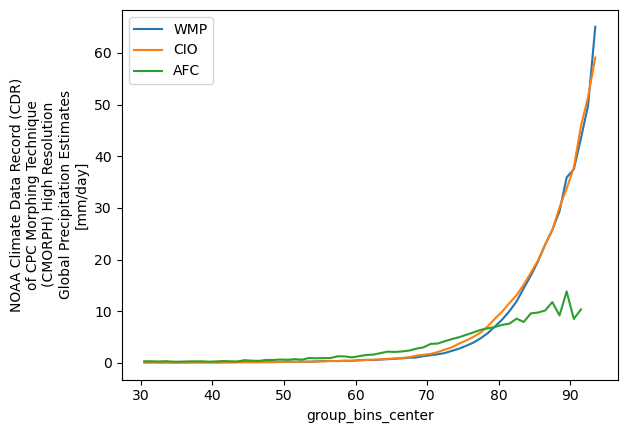

In [30]:
for region in [wmp_region(), cio_region(), afc_region()]:
    crh_reg = crh.where(pr>0, np.nan).sel(region.get_slices())
    pr_reg = pr.where(pr>0, np.nan).sel(region.get_slices())
    # Align crh and pr to ensure they have the same 'time' coordinates
    crh_aligned, pr_aligned = xr.align(crh_reg, pr_reg, join='inner')
    crh_bins = np.arange(30, 95, 1)
    grouped_pr = pr_aligned.groupby_bins(crh_aligned, bins=crh_bins).mean()
    crh_midpoints = (crh_bins[1:]+crh_bins[:-1])/2
    c = grouped_pr.plot(label=region.name)
    plt.legend()
    